# Generating topography 
This notebook will run through the bare necessities for developing a higher resolution topography. 

Currently, this just takes the `hgrid.nc` from the ACCESS-OM2-01 input files, and multiplies the resolution of this by some factor. This example sets this factor to 3 in order to maintain consistency of tracer points between the high and low resolution grids. This justification may become unnecessary into the future. 


In [1]:
import xarray as xr
import xesmf as xe
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
print(os.getcwd())

import warnings
warnings.filterwarnings('ignore')

# Set important directory paths
om2path = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolpath = "/g/data/v45/ahg157/tools/" ## Compiled tools needed for construction of mask tables
    
from regional_model_scripts import input_datasets, interp_segment,prepare_segments, time_rotate,regrid_runoff,sel_hgrid_indices


from dask.distributed import Client
client = Client()
client

/home/149/ab8992/cosima_regional/mom6-regional-scripts


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43819/status,
Dashboard: /proxy/43819/status,Workers: 1
Total threads: 1,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41217,Workers: 1
Dashboard: /proxy/43819/status,Total threads: 1
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:35583,Total threads: 1
Dashboard: /proxy/43345/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:45607,


#### Choose domain and set path to input and run directories...
- Taken from original notebook

Text(0.5, 1.0, 'z-coord_understanding domain')

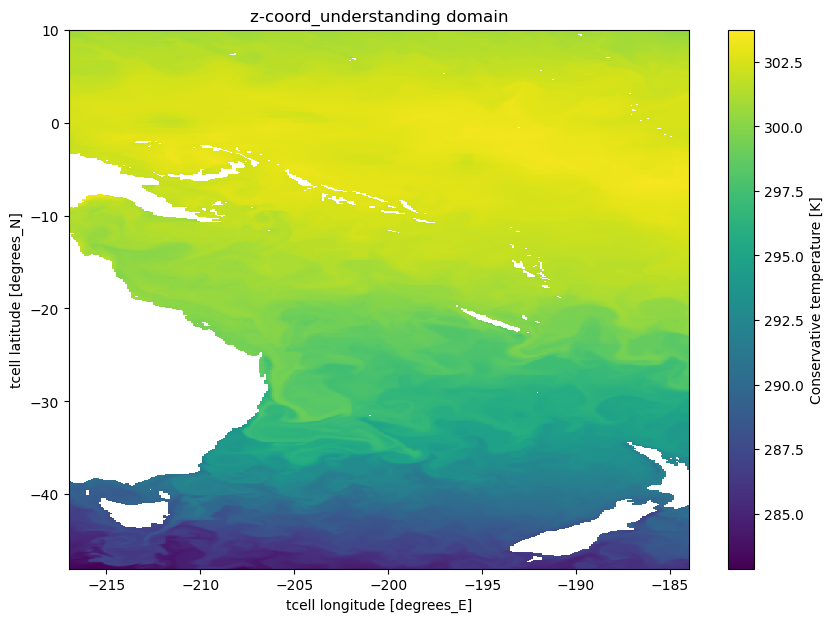

In [2]:
## Choose your coordinates and the name of your experiment
yextent = [-48, 10]
xextent = [-217 , -184]

expt_name = "z-coord_understanding"

# ## Place where all your input files go
# path = f"/scratch/v45/jr5971/mom6/regional_configs/{expt_name}/"

# ## Directory where you'll run the experiment from
# rundir = f"/home/581/jr5971/mom6_rundirs/{expt_name}"

## Place where all your input files go
path = f"/scratch/v45/jr5971/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/581/jr5971/mom6_rundirs/{expt_name}/"

for i in [path,rundir]:
    try:
        os.mkdir(i)
    except:
        pass

full_domain = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc")

# domain.tau_x.sel(yu_ocean=slice(-49, -5), xu_ocean=slice(-217, -183)).isel(time = 0).plot()
domain = full_domain.surface_temp.sel(yt_ocean=slice(yextent[0], yextent[1]), xt_ocean=slice(xextent[0],xextent[1])).isel(time = 0)
fig,ax = plt.subplots(1,figsize = (10,7))

domain.plot(ax = ax)
ax.set_title(f"{expt_name} domain")

# Key steps for generating higher res topog. 
## 1. Load in global hgrid from `om2path`, and cut this down to size for the domain extent

In [3]:
# Get new hgrid based on the geographical extent specified above
hgrid = xr.open_dataset(om2path + "ocean_hgrid.nc")

# get x and y indices of hgrid
x_indices_hgrid = sel_hgrid_indices(hgrid.x.isel(nyp = 1000,nxp = slice(0,None,2)),xextent)  ## As long as it's away from the north pole things are ok since lon doesn't vary with lat
y_indices_hgrid = sel_hgrid_indices(hgrid.y.isel(nxp = 0,nyp = slice(0,None,2)),yextent) 

encoding = {'x': {'_FillValue': None},
            'y': {'_FillValue': None},
            "dx": {"_FillValue": None},
            'dy': {'_FillValue': None},
            'angle_dx': {'_FillValue': None},
            'area': {'_FillValue': None}
            }  

hgrid_new = hgrid.isel(
    nyp = slice(y_indices_hgrid[0] , y_indices_hgrid[1] ),
    nxp = slice(x_indices_hgrid[0] , x_indices_hgrid[1] ),
    ny = slice(y_indices_hgrid[0] , y_indices_hgrid[1] - 1 ),
    nx = slice(x_indices_hgrid[0] , x_indices_hgrid[1] - 1 ))

### 2. Increase resolution of domain hgrid
Here, we take the original coordinate values in the x & y directions, divide the spaces between each consecutive pair by three, and add 2 more equally spaced values in between each original pair to get 3 times the original resolution. 
- We then create a meshgrid with these new values for both corner and tracer points and make a new dataset that has these new arrays representing the new lat and lon values

**NOTE**: All the printing was just a sanity check and can be removed eventually

In [4]:
x = hgrid_new.x.isel(nyp=0).values # get x-coordinate values
# print(f"first five points of x on original supergrid are :{x[:5]}, \n and space between points is {round(x[1]-x[0],2)}")
xc = x[::2] # Select every second x-value, i.e the "corner points" of a staggered grid
xc3_delta = (xc[1:] - xc[:-1]) / 3 # Divide the space between each pair of points by three. 
xc3 = np.concatenate([xc, xc[:-1]+xc3_delta, xc[:-1]+2*xc3_delta]) # add in the extra variables. 
xc3 = np.sort(xc3)
# print(f"\n first five new corner points of hgrid are: {xc3[:5]}, \n and space between points is {xc3[1]-xc3[0]}")
xt3 = (xc3[1:] + xc3[:-1])/2
# print(f"\n first five new tracer points of hgrid are: {xt3[:5]}, \n and space between tracer points is {xt3[1]-xt3[0]}")
y = hgrid_new.y.isel(nxp=0).values
yc = y[::2]
yc3_delta = (yc[1:] - yc[:-1]) / 3
yc3 = np.sort(np.concatenate([yc, yc[:-1]+yc3_delta, yc[:-1]+2*yc3_delta]))
# print(f"\n first five new corner points of hgrid are: {yc3[-5:]}, \n and space between points is {yc3[-1]-yc3[-2]}")
yt3 = (yc3[1:] + yc3[:-1])/2
# print(f"\n first five new tracer points of hgrid are: {yt3[:5]}, \n and space between tracer points is {yt3[1]-yt3[0]}")
# print(f"\n difference between the corner and tracer points in x are: {xt3[0]-xc3[0]} degrees longitude")

# broadcast to meshgrid
XC, YC = np.meshgrid(xc3, yc3)
XT, YT = np.meshgrid(xt3, yt3)

# create output dataset
ds = xr.Dataset({
    "grid_lon": (['grid_yc', 'grid_xc'], XC),
    'grid_lat': (['grid_yc', 'grid_xc'], YC),
    'grid_lont': (['grid_yt', 'grid_xt'], XT),
    'grid_latt': (['grid_yt', 'grid_xt'], YT),
})

ds.to_netcdf(path + 'grid_30th-deg.nc')

# hgrid_new = ds

#### 2.2 Generate hgrid from high-res meshgrid created above

In [5]:
args = "--grid_type from_file --my_grid_file grid_30th-deg.nc".split(" ")
print("MAKE HGRID", subprocess.run([toolpath + "make_hgrid"] + args, cwd=path), sep="\n")
subprocess.run(["mv","horizontal_grid.nc","hgrid.nc"],cwd=path)

MAKE HGRID
CompletedProcess(args=['/g/data/v45/ahg157/tools/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid_30th-deg.nc'], returncode=0)


CompletedProcess(args=['mv', 'horizontal_grid.nc', 'hgrid.nc'], returncode=0)

### 3. Load in GEBCO2022 topography dataset, cut down to region of interest, and use FRE-tools to interpolate data onto higher resolution hgrid

In [6]:
gebco_path = '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc'
gebco_ds = xr.open_dataset(gebco_path)
geb_idx = {'W':xextent[0]+360, 'E':xextent[1]+360,
           'S':yextent[0], 'N':yextent[1]}
geb_eac = gebco_ds.sel(lon=slice(geb_idx['W'], geb_idx['E']),
                       lat=slice(geb_idx['S'], geb_idx['N']))['elevation'].astype("float")


geb_eac.attrs['missing_value'] = -1e20
geb_eac.to_netcdf(path+'gebco_eac.nc')

In [3]:
geb_eac = xr.open_dataset(path+'gebco_eac.nc')

In [4]:
geb_eac

<xarray.Dataset>
Dimensions:    (lon: 7920, lat: 13920)
Coordinates:
  * lon        (lon) float64 143.0 143.0 143.0 143.0 ... 176.0 176.0 176.0 176.0
  * lat        (lat) float64 -48.0 -47.99 -47.99 -47.99 ... 9.99 9.994 9.998
Data variables:
    elevation  (lat, lon) float64 ...

In [5]:
depth = geb_eac.elevation
depth

<xarray.DataArray 'elevation' (lat: 13920, lon: 7920)>
[110246400 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 143.0 143.0 143.0 143.0 ... 176.0 176.0 176.0 176.0
  * lat      (lat) float64 -48.0 -47.99 -47.99 -47.99 ... 9.985 9.99 9.994 9.998
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [8]:
depth.max()

<xarray.DataArray 'elevation' ()>
array(4404.)

Right so in this region, the maximum depth is about 4500m. So if we choose to go down to around 5000m we should be safe? 

In [52]:
toolpath = "/g/data/v45/jr5971/FRE-NCtools/build/tools/make_vgrid/"

In [25]:
args = "--nbnds 3 --bnds 10,200,1000 --nz 10,20 --grid_name vgrid1".split(" ")
print("MAKE VGRID", subprocess.run([toolpath + "make_vgrid"] + args, cwd=path),
      sep="\n")

MAKE VGRID
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build/tools/make_vgrid/make_vgrid', '--nbnds', '3', '--bnds', '10,200,1000', '--nz', '10,20', '--grid_name', 'vgrid1'], returncode=0)


In [31]:
args = "--nbnds 4 --bnds 0,180,200,5000 --nz 18,2,30 --center c_cell --grid_name vgrid2".split(" ")
print("MAKE VGRID", subprocess.run([toolpath + "make_vgrid"] + args, cwd=path),
      sep="\n")

MAKE VGRID
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build/tools/make_vgrid/make_vgrid', '--nbnds', '4', '--bnds', '0,180,200,5000', '--nz', '18,2,30', '--center', 'c_cell', '--grid_name', 'vgrid2'], returncode=0)


In [33]:
args = "--nbnds 6 --bnds 0,100,120,200,220,5000 --nz 20,2,8,2,30 --center c_cell --grid_name vgrid3".split(" ")
print("MAKE VGRID", subprocess.run([toolpath + "make_vgrid"] + args, cwd=path),
      sep="\n")

MAKE VGRID
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build/tools/make_vgrid/make_vgrid', '--nbnds', '6', '--bnds', '0,100,120,200,220,5000', '--nz', '20,2,8,2,30', '--center', 'c_cell', '--grid_name', 'vgrid3'], returncode=0)


In [54]:
args = "--nbnds 6 --bnds 0,100,200,1000,2000,4500 --nz 30,20,30,20,50 --center c_cell --grid_name vgridtest1".split(" ")
print("MAKE VGRID", subprocess.run([toolpath + "make_vgrid"] + args, cwd=path),
      sep="\n")

MAKE VGRID
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build/tools/make_vgrid/make_vgrid', '--nbnds', '6', '--bnds', '0,100,200,1000,2000,4500', '--nz', '30,20,30,20,50', '--center', 'c_cell', '--grid_name', 'vgridtest1'], returncode=0)


In [4]:
vgrid1 = xr.open_dataset(path+'vgrid1.nc')
vgrid2 = xr.open_dataset(path+'vgrid2.nc')
vgrid3 = xr.open_dataset(path+'vgrid3.nc')
vgridtest = xr.open_dataset(path+'vgridtest.nc')
vgridtest1 = xr.open_dataset(path+'vgridtest1.nc')
vgridtest.zeta.plot.scatter(label='test'); vgridtest1.zeta.plot.scatter(label='test1')
vgrid1.zeta.plot.scatter(label='eg1'); vgrid2.zeta.plot.scatter(label='eg2'); vgrid3.zeta.plot.scatter(label='eg3')
om2_vgrid.zeta.plot.scatter(label='om2')
plt.legend()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'cfradial1', 'furuno', 'gamic', 'gini', 'iris', 'odim', 'pydap', 'radolan', 'rainbow', 'rasterio', 'wradlib-cfradial1', 'wradlib-cfradial2', 'wradlib-furuno', 'wradlib-gamic', 'wradlib-iris', 'wradlib-odim', 'wradlib-rainbow', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

So this vgrid is really quite simple...
- We've got depth up the y-axis, and grid level on the x-axis. 
    - additionally, the density of the points increases with the increase in z-level

In [83]:
om2

<xarray.DataArray 'zeta' (nzv: 151)>
array([0.000000e+00, 5.412808e-01, 1.082562e+00, 1.680735e+00, 2.278908e+00,
       2.939953e+00, 3.600997e+00, 4.331521e+00, 5.062046e+00, 5.869350e+00,
       6.676655e+00, 7.568810e+00, 8.460964e+00, 9.446885e+00, 1.043281e+01,
       1.152234e+01, 1.261188e+01, 1.381593e+01, 1.501997e+01, 1.635055e+01,
       1.768113e+01, 1.915154e+01, 2.062195e+01, 2.224687e+01, 2.387179e+01,
       2.566746e+01, 2.746312e+01, 2.944746e+01, 3.143179e+01, 3.362460e+01,
       3.581741e+01, 3.824057e+01, 4.066373e+01, 4.334140e+01, 4.601908e+01,
       4.897796e+01, 5.193684e+01, 5.520640e+01, 5.847596e+01, 6.208874e+01,
       6.570151e+01, 6.969342e+01, 7.368533e+01, 7.809601e+01, 8.250670e+01,
       8.737988e+01, 9.225307e+01, 9.763700e+01, 1.030209e+02, 1.089687e+02,
       1.149166e+02, 1.214869e+02, 1.280572e+02, 1.353144e+02, 1.425717e+02,
       1.505868e+02, 1.586020e+02, 1.674530e+02, 1.763040e+02, 1.860765e+02,
       1.958489e+02, 2.066365e+02, 2.174242e+02, 2.293296e+02, 2.412350e+02,
       2.543701e+02, 2.675053e+02, 2.819920e+02, 2.964787e+02, 3.124492e+02,
       3.284196e+02, 3.460166e+02, 3.636136e+02, 3.829906e+02, 4.023675e+02,
       4.236883e+02, 4.450091e+02, 4.684475e+02, 4.918859e+02, 5.176242e+02,
       5.433625e+02, 5.715899e+02, 5.998174e+02, 6.307275e+02, 6.616377e+02,
       6.954248e+02, 7.292120e+02, 7.660668e+02, 8.029216e+02, 8.430255e+02,
       8.831294e+02, 9.266482e+02, 9.701670e+02, 1.017244e+03, 1.064320e+03,
       1.115068e+03, 1.165816e+03, 1.220309e+03, 1.274803e+03, 1.333076e+03,
       1.391349e+03, 1.453384e+03, 1.515420e+03, 1.581154e+03, 1.646887e+03,
       1.716205e+03, 1.785522e+03, 1.858264e+03, 1.931006e+03, 2.006975e+03,
       2.082944e+03, 2.161913e+03, 2.240881e+03, 2.322601e+03, 2.404321e+03,
       2.488533e+03, 2.572745e+03, 2.659189e+03, 2.745633e+03, 2.834054e+03,
       2.922475e+03, 3.012631e+03, 3.102788e+03, 3.194453e+03, 3.286119e+03,
       3.379089e+03, 3.472058e+03, 3.566145e+03, 3.660233e+03, 3.755274e+03,
       3.850315e+03, 3.946166e+03, 4.042017e+03, 4.138551e+03, 4.235086e+03,
       4.332197e+03, 4.429308e+03, 4.526903e+03, 4.624497e+03, 4.722497e+03,
       4.820497e+03, 4.918835e+03, 5.017173e+03, 5.115794e+03, 5.214414e+03,
       5.313270e+03, 5.412126e+03, 5.511177e+03, 5.610229e+03, 5.709443e+03,
       5.808657e+03])
Dimensions without coordinates: nzv
Attributes:
    units:          meters
    standard_name:  vertical_grid_vertex
    long_name:      vgrid
    author:         Kial Stewart

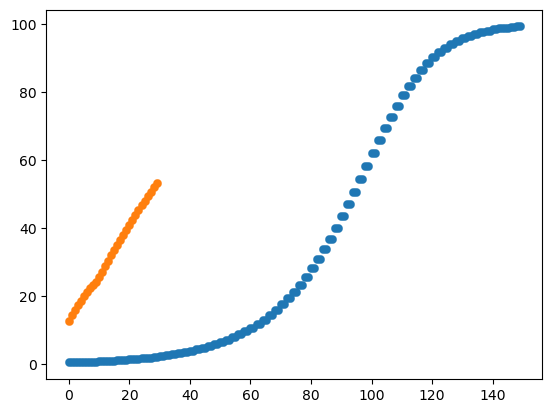

In [82]:
om2diff = np.diff(om2)
testdiff = np.diff(vgrid1.zeta)
plt.scatter(np.arange(len(om2diff)), om2diff, linewidths=0.2)
plt.scatter(np.arange(len(testdiff)), testdiff, linewidths=0.2)

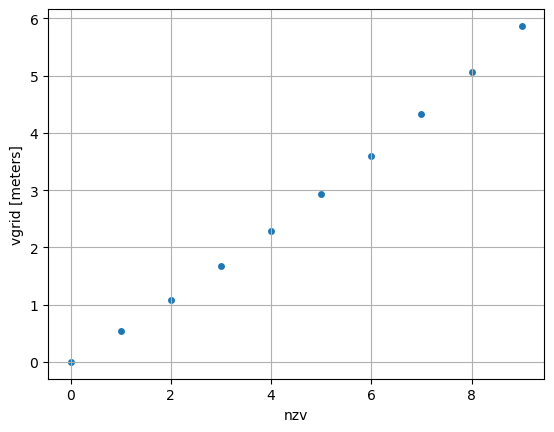

In [85]:
# om2 = om2_vgrid.zeta
om2[:10].plot.scatter()
# vgridtest.zeta[:60].plot.scatter()
plt.grid()

Is this something where we could double the vertical resolution simply using the ...

In [67]:
om2[:6].values

array([0.        , 0.54128077, 1.08256153, 1.68073468, 2.27890783,
       2.93995265])

So, we simply want the same shape as the om2 vgrid, but with more levels. But also, we don't need it to go all the way to 6000m!

In order to generate regions of constant resolution the user should specify 3 consecutive regions of constant resolution (only 2 for the first and last regions are required)

In [32]:
vgrid2 = xr.open_dataset(path+'vgrid2.nc')
vgrid2

<xarray.Dataset>
Dimensions:  (nzv: 51)
Dimensions without coordinates: nzv
Data variables:
    zeta     (nzv) float64 ...
Attributes:
    grid_version:          0.2
    code_release_version:  2022.02
    git_hash:              83acb799f47dfa27b433a131e9f7c1310767cc59
    creationtime:          Tue Mar 14 15:33:12 2023
    hostname:              gadi-cpu-bdw-0019.gadi.nci.org.au
    history:               /g/data/v45/jr5971/FRE-NCtools/build/tools/make_vg...

In [2]:
om2_vgrid=xr.open_dataset('/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/ocean_vgrid.nc')
om2_vgrid

<xarray.Dataset>
Dimensions:  (nzv: 151)
Dimensions without coordinates: nzv
Data variables:
    zeta     (nzv) float64 ...

In [6]:
vcoord_old = xr.open_dataset('/home/581/jr5971/mom6_rundirs/mom6_003/inputdir/vcoord.nc')
vcoord_old

<xarray.Dataset>
Dimensions:         (st_edges_ocean: 76, st_ocean: 75)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    *empty*
Attributes:
    filename:   ocean.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    Thu Jan 21 08:51:33 2021: ncks -v st_ocean,st_edges_ocean /g/...
    NCO:        netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net,...

In [7]:
eac_kds150 = xr.open_dataarray('/home/581/jr5971/vertical_grid_for_ocean_models/eac-003_KDS150-super-vgrid.nc')
kds150_vgrid = xr.open_dataarray('/home/581/jr5971/vertical_grid_for_ocean_models/eac-003_KDS150_ocean_vertical_grid.nc')

In [8]:
st_edges_ocean = eac_kds150[::2]
st_ocean = eac_kds150[1::2]
st_ocean[:4].values

array([0.1033368 , 0.3163936 , 0.54261106, 0.78280212])

In [11]:
vcoord_new = xr.Dataset(
    data_vars=dict(
        st_edges_ocean=(['st_edges_ocean'],st_edges_ocean.values),
        st_ocean=(['st_ocean'],st_ocean.values)))


In [12]:
vcoord_new

<xarray.Dataset>
Dimensions:         (st_edges_ocean: 151, st_ocean: 150)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 0.2067 ... 4.388e+03 4.458e+03
  * st_ocean        (st_ocean) float64 0.1033 0.3164 ... 4.353e+03 4.423e+03
Data variables:
    *empty*

In [13]:
vcoord_new.attrs = dict(
    filename = 'ocean.nc',
    title = 'EAC-003',
    grid_type = 'mosaic',
    author = 'JR',)

In [14]:
vcoord_new['st_ocean'].attrs = dict(
    long_name = 'tcell zstar depth',
    units = 'meters',
    cartesian_axis = 'Z',
    positive = 'down',
    edges = 'st_edges_ocean')
vcoord_new['st_edges_ocean'].attrs = dict(
    long_name = 'tcell zstar depth edges',
    units = 'meters',
    cartesian_axis = 'Z',
    positive = 'down')
    

In [15]:
vcoord_new.to_netcdf('/scratch/v45/jr5971/mom6/regional_configs/eac_003-v2/vcoord.nc')

Text(0.5, 1.0, 'Vertical resolution of OM2-01 & EAC-003')

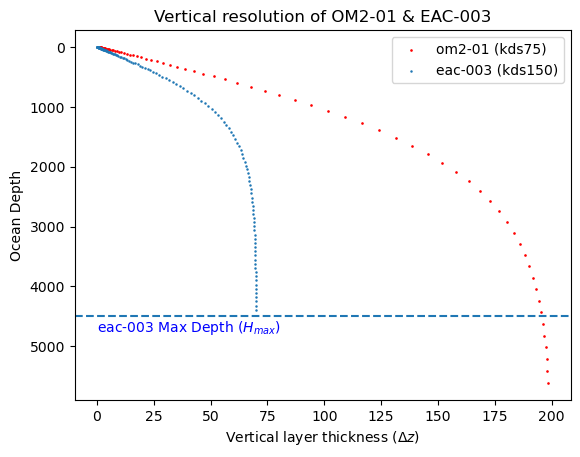

In [65]:
om2_vgrid = om2[::2]
om2_dz = np.diff(om2_vgrid)
eac_dz = np.diff(kds150_vgrid)
plt.scatter(om2_dz, om2_vgrid[:-1], s=0.8, c='r',label='om2-01 (kds75)')
plt.scatter(eac_dz, kds150_vgrid[:-1], s=0.6, label='eac-003 (kds150)')
plt.gca().invert_yaxis()
plt.xlabel('Vertical layer thickness ($\Delta z$)')
plt.ylabel('Ocean Depth')
plt.axhline(y = 4500, ls='--')
plt.text(x=0, y=4750, s='eac-003 Max Depth ($H_{max}$)', c='blue')
plt.legend()
plt.title('Vertical resolution of OM2-01 & EAC-003')

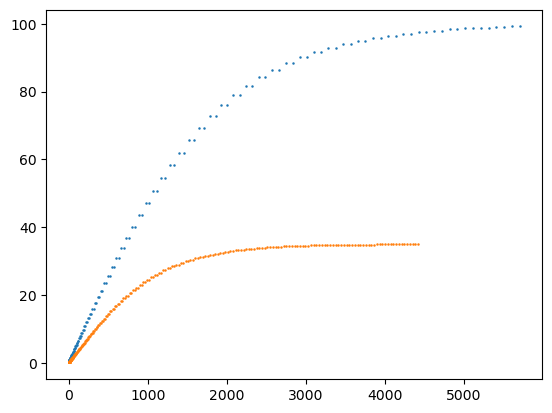

In [42]:
eac_dz = np.diff(eac_kds150)
om2_dz = np.diff(om2)

plt.scatter(om2[:-1:2], om2_dz, s=0.6); 
plt.scatter(eac_kds150[:-1], eac_dz, s=0.6)
# eac_kds150.plot.scatter()
# om2.plot.scatter()

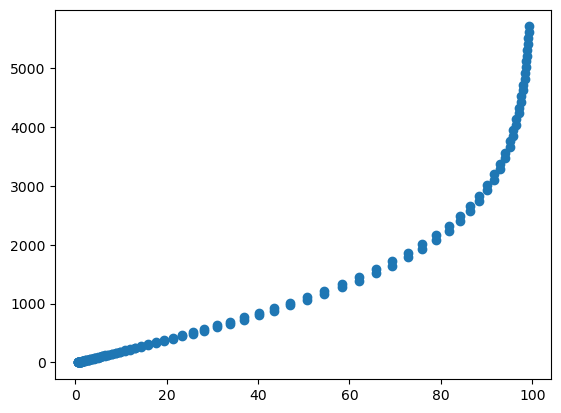

In [17]:
om2 = om2_vgrid.zeta
dz = np.diff(om2)
plt.scatter(dz, om2[:-1])

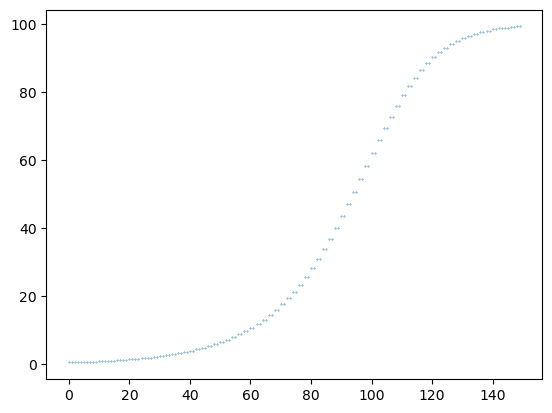

In [21]:
plt.scatter(np.arange(len(dz)), dz, s=0.1)

In [24]:
kds1 = xr.open_dataarray('/home/581/jr5971/vertical_grid_for_ocean_models/eac-003-super-vgrid.nc')
kds1

<xarray.DataArray 'zeta' (nzv: 341)>
[341 values with dtype=float64]
Dimensions without coordinates: nzv
Attributes:
    units:          meters
    standard_name:  vertical_grid_vertex
    long_name:      vertical_super_grid_for_MOM5:_depth_at_the_top_and_middle...
    author:         Kial Stewart

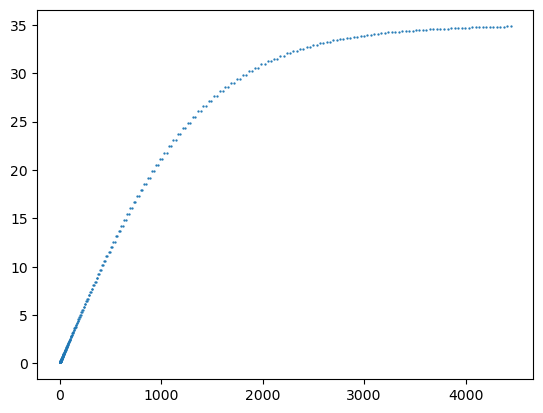

In [27]:
dz1 = np.diff(kds1)
plt.scatter(kds1[:-1], dz1, s=0.4)

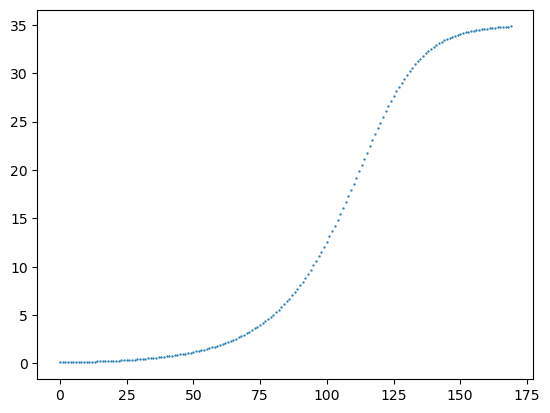

In [32]:
plt.scatter(np.arange(len(dz1[::2])), dz1[::2], s=0.4)

NameError: name 'vgrid' is not defined

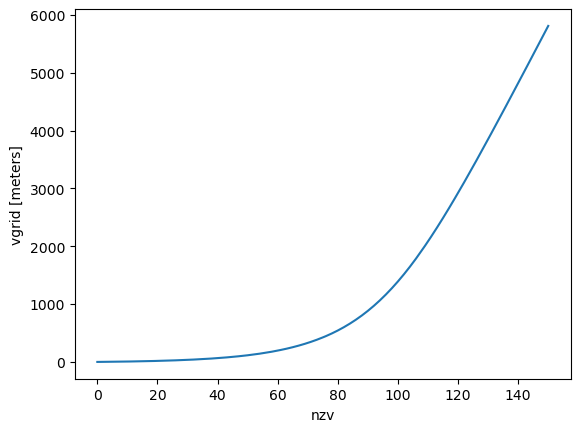

In [6]:
om2_vgrid.zeta.plot()
vgrid.zeta.plot()

#### 3.2 Generate `ocean_mosaic.nc` from the horizontal hgrid

In [7]:
args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic"] + args, cwd=path), sep="\n")

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC
CompletedProcess(args=['/g/data/v45/ahg157/tools/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


#### 3.3 Interpolating GEBCO2022 onto hi-res mosaic grid.
Here is where things get interesting - I had to re-compile the FRE-NCtools, activating MPI capabilities 
- See hive forum post: https://forum.access-hive.org.au/t/fre-nctools-make-topog-mpi-error-when-generating-topography/436/5
    - The path to these new tools is `/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/`. 
    - However running this in the Jupyter notebook still didn't work, as it couldn't parallelise from within Python as I understand it. So, I set it up as a PBS job: The script can be found at this path in my scratch directory - `/scratch/v45/jr5971/mom6/regional_configs/mom6_003/mpi_topog`
    I'm just not entirely sure how to incorporate the PBS execution from within the JupyterLab environment. 


In [8]:
# print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic"] + args, cwd=path), sep="\n")

args = "--mosaic ocean_mosaic.nc --topog_type realistic --topog_file gebco_eac.nc --topog_field elevation --scale_factor -1 --output topog.nc".split(" ")

print(
    subprocess.run(["/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/make_topog_parallel"] + args,cwd = path)
)



==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/make_topog_parallel', '--mosaic', 'ocean_mosaic.nc', '--topog_type', 'realistic', '--topog_file', 'gebco_eac.nc', '--topog_field', 'elevation', '--scale_factor', '-1', '--output', 'topog.nc'], returncode=0)


## Run deseas script to get rid of little lakes and enclosed bays

In [9]:

args = f"topog.nc deseas_topog.nc".split(" ")

subprocess.run(["/home/149/ab8992/tools/topogtools/deseas"] + args,cwd = path)


## Now just fiddle with the metadata to make sure that the array returned
## by 'deseas' will work with mom6 
#  
topog = xr.open_dataset(path + "topog.nc")
deseas = xr.open_dataset(path + "deseas_topog.nc")
topog.depth[:,:] = deseas.depth.values
topog.expand_dims({'ntiles':1}).to_netcdf(path + "new_topog.nc",mode = "w",encoding={"depth":{'_FillValue': None}} )

subprocess.run(["mv","new_topog.nc","topog.nc"],cwd=path)



       26789          97
         130          10
          86           8
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7
          86           7


Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/process.py", line 188, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/